# Data reduction workflow for files generated on Larmor instrument

Some addhoc approximations will need to be done in order to satisfy SANS2D workflow, e.g direct measurments, tramsmission fraction. 

In [2]:
import matplotlib.pyplot as plt
import scipp as sc
from ess import loki, sans
import scippneutron as scn
import plopp as pp
pp.patch_scipp()

In [3]:
scn.__version__

'22.12.4'

## Define reduction workflow parameters

We define here whether to include the effects of gravity,
as well as common time-of-flight, wavelength and $Q$ bins for all the measurements.

We also define a range of wavelengths for the monitors that are considered to not be part of the background.

In [4]:
# Include effects of gravity?
gravity = True

#TODO: Check whether this one is needed.
tof_bins = sc.linspace(dim='tof', start=0, stop=100000, num=2, unit='us')
tof_bins = sc.to_unit(tof_bins, 'ns')
wavelength_bins = sc.linspace(dim='wavelength', start=0.9, stop=13.5, num=110,
                              unit='angstrom')

q_bins = sc.linspace(dim='Q', start=0.008, stop=0.6, num=55, unit='1/angstrom')

# Define the range of wavelengths for the monitors that are considered
# to not be part of the background - this will need to be changed
monitor_non_background_range = sc.array(dims=['wavelength'],
                                        values=[0.7, 17.1], unit='angstrom')

## Loading data files

We load the following files:

- The direct beam function for the main detector (gives detector efficiency as a function of wavelength)
- The sample measurement
- The direct measurement: this is the run with the empty sample holder/cuvette
- the background measurement: this is the run with only the solvent which the sample is placed in

In [5]:
ds = sc.Dataset()

sample_run_number = 60345
sample_transmission_run_number = 60344
background_run_number = 60337
background_transmission_run_number = 60336

path = '/Users/wojciechpotrzebowski/SCIPP_SPACE/loki_detector_test/2022-06-24_calibrated_nexus_files/'
direct_beam = loki.io.load_rkh_wav(f'{path}/DirectBeam_20feb_full_v3.dat')

out = scn.load_nexus(data_file=f'{path}/{sample_run_number}-2022-02-28_2215_fixed.nxs')
out = out.bin({tof_bins.dim: tof_bins})
ds['sample'] = out 
#edges=sc.linspace('tof', 91, 1e8, 100, unit='ns')
#binned_data = sc.bin(sample, edges=[edges])
#ds['sample'] = binned_data

out = scn.load_nexus(data_file=f'{path}/{sample_transmission_run_number}-2022-02-28_2215_fixed.nxs')
out = out.bin({tof_bins.dim: tof_bins})
ds['sample_transmission'] = out
#binned_data = sc.bin(sample_transmission, edges=[edges])
#ds['sample_transmission'] = binned_data

#TODO: How about direct?
#ds['direct'] = scn.load(filename=f'{path}/LARMOR000{background_run_number}.nxs')

out = scn.load_nexus(data_file=f'{path}/{background_run_number}-2022-02-28_2215_fixed.nxs')
out = out.bin({tof_bins.dim: tof_bins})
ds['background'] = out

out = scn.load_nexus(data_file=f'{path}/{background_transmission_run_number}-2022-02-28_2215_fixed.nxs')
out = out.bin({tof_bins.dim: tof_bins})
ds['background_transmission'] = out


FrameworkManager-[Notice] Welcome to Mantid 6.5.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.5
DownloadInstrument-[Notice] All instrument definitions up to date
LoadRKH-[Notice] LoadRKH started
LoadRKH-[Notice] LoadRKH successful, Duration 0.00 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds


## Apply corrections to pixel positions

We apply some corrections to the detector pixel and monitor positions,
as the geometry stored in the file is inaccurate.

In [6]:
#sample_position 0, 0, 0 wrt to source?
ds.coords["sample_position"] = sc.vector(value=[0.0, 0.0, 0.0], unit='m')
#sample_pos_z_offset = 0.1 * sc.units.m
#bench_pos_y_offset = 0.001 * sc.units.m

ds.coords["pixel_width"] = 0.0075 * sc.units.m
ds.coords["pixel_height"] = 0.0117188 * sc.units.m

x_offset = 0.028 * sc.units.m
y_offset = 0.01195 * sc.units.m

# Now shift pixels positions to get the correct beam center
ds.coords['position'].fields.x += x_offset
ds.coords['position'].fields.y += y_offset
# Change sample position
#ds.coords["sample_position"].fields.z += sample_pos_z_offset
# Apply bench offset to pixel positions
#ds.coords["position"].fields.y += bench_pos_y_offset

#TOOD: We don't have this one either
#for key in ds:
#    ds[key].attrs["monitor4"].value.coords["position"].fields.z += monitor4_pos_z_offset

In [7]:
#Need to histogram in order to make plopp instrument view working
start_tof = ds.coords['tof'][0].values
end_tof = ds.coords['tof'][-1].values
nbins = 5
tof_edges = sc.linspace(dim='tof', start=start_tof, stop=end_tof, num=nbins, unit='ns')
# histogrammed = ds.hist(tof=tof_edges)
# scn.instrument_view(histogrammed['sample']['tof', 1], pixel_size=0.01)

In [8]:
# sample = histogrammed['sample'].copy(deep=False)

# sample.coords['x'] = sample.coords['position'].fields.x
# sample.coords['y'] = sample.coords['position'].fields.y
# sample.coords['z'] = sample.coords['position'].fields.z

# in_node = pp.input_node(sample)
# in_node.name = 'Input node'

# import ipywidgets as ipw
# # Make a range slider
# slider = ipw.IntSlider(max=nbins-1,
#                             description='tof bin',
#                             layout={'width': '400px'})

# slider_node = pp.widget_node(slider)
# slider_node.name = 'Slider node'

# slice_node = pp.node(
#     lambda da, ind: da['tof', ind])(da=in_node, ind=slider_node)
# slice_node.name = 'Slice by tof'


# fig3d = pp.figure3d(slice_node, x='x', y='y', z='z', norm='log', pixel_size=0.01)

# from plopp.widgets import Box, ToggleTool, TriCutTool
# tri_cutter = TriCutTool(fig3d)

# fig3d.toolbar['cut3d'] = ToggleTool(callback=tri_cutter.toggle_visibility,
#                                       icon='cube',
#                                       tooltip='Hide/show spatial cutting tool')

# pp.widgets.Box([fig3d,  tri_cutter, slider])

In [9]:
# scn.instrument_view(histogrammed['sample']['tof', 1], pixel_size=0.01)

## Masking

The next step is to mask noisy and saturated pixels,
as well as a time-of-flight range that contains spurious artifacts from the beamline components.

**Note:** We use programatic masks here and not those stored in xml files.

### Mask bad pixels

We mask the edges of the detector, which are usually noisy.
We also mask the region close to the center of the beam,
so as to not include saturated pixels in our data reduction.

In [10]:
mask_edges = (
    (sc.abs(ds.coords['position'].fields.x - x_offset) > sc.scalar(0.45, unit='m')) |
    (sc.abs(ds.coords['position'].fields.y - y_offset) > sc.scalar(0.45, unit='m')))

mask_center = sc.sqrt(
    ds.coords['position'].fields.x**2 +
    ds.coords['position'].fields.y**2) < sc.scalar(0.035, unit='m')


for key in ds:
    ds[key].masks['edges'] = mask_edges
    ds[key].masks['center'] = mask_center

We can inspect that the coordinate corrections and masking were applied correctly by opening the instrument view.

In [11]:
histogrammed = ds.hist(tof=tof_edges)
scn.instrument_view(histogrammed['sample']['tof', 1], pixel_size=0.01)

Box(children=(Figure(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home',…

### Mask in time-of-flight

This could be implemented as masking specific time bins for a specific region in space,
but for now we keep it simple.

In [12]:
tof_bins 

<scipp.Variable> (tof: 2)    float64             [ns]  [0, 1e+08]

In [13]:
# tof = data.coords['tof']
# tof_masked_region = sc.less(tof['tof',1:], 1500.0 * sc.units.us) | \
#                          (sc.greater(tof['tof',:-1], 17500.0 * sc.units.us) & \
#                           sc.less(tof['tof',1:], 19000.0 * sc.units.us))

# for key in ds:
#     ds[key].masks['bins'] = tof_masked_region
    

mask_tof_min = sc.scalar(17500.0, unit='us')
mask_tof_max = sc.scalar(19000.0, unit='us')

mask_tof_min = sc.to_unit(mask_tof_min, 'ns')
mask_tof_max = sc.to_unit(mask_tof_max, 'ns')

tof_masked_region = sc.concat([ds.coords['tof']['tof', 0],
                               mask_tof_min, mask_tof_max,
                               ds.coords['tof']['tof', -1]], dim='tof')

binned = sc.Dataset()
for key in ds:
    binned[key] = sc.bin(ds[key], edges=[tof_masked_region])
    binned[key].masks['bragg_peaks'] = sc.array(dims=['tof'], values=[False, True, False])
    binned[key].attrs['monitor_1'].values.coords['source_position'] = sc.vector(value=[0.0, 0.0, -25.61], unit='m')
    binned[key].attrs['monitor_2'].values.coords['source_position'] = sc.vector(value=[0.0, 0.0, -25.61], unit='m')
#binned

The 'edges', 'groups', and 'erase' keyword arguments are deprecated. Use, e.g., 'sc.bin(da, x=x_edges)' or 'sc.group(da, groups)'. See the documentation for details.
The 'edges', 'groups', and 'erase' keyword arguments are deprecated. Use, e.g., 'sc.bin(da, x=x_edges)' or 'sc.group(da, groups)'. See the documentation for details.
The 'edges', 'groups', and 'erase' keyword arguments are deprecated. Use, e.g., 'sc.bin(da, x=x_edges)' or 'sc.group(da, groups)'. See the documentation for details.
The 'edges', 'groups', and 'erase' keyword arguments are deprecated. Use, e.g., 'sc.bin(da, x=x_edges)' or 'sc.group(da, groups)'. See the documentation for details.


## Use to_I_of_Q workflow

We now reduce the sample and the background measurements to `Q` using the `sans.to_I_of_Q` workflow.

In that process,
the intensity as a function of `Q` is normalized using the direct measurement and direct beam function.

The workflow needs monitor data from the sample, background, and direct runs to compute the normalization.
It accepts those in the form of a dictionaries:

In [14]:
#TODO: It needs to be sorted out
sample_monitors = {'incident': binned['sample'].attrs["monitor_1"].value,
                   'transmission': binned['sample'].attrs["monitor_2"].value}

background_monitors = {'incident': binned['background'].attrs["monitor_1"].value,
                       'transmission': binned['background'].attrs["monitor_2"].value}

In [15]:
start_tof = ds.coords['tof'][0].values
end_tof = ds.coords['tof'][-1].values
nbins = 481
tof_edges = sc.linspace(dim='tof', start=start_tof, stop=end_tof, num=nbins, unit='ns')


In [16]:
sample_monitors['incident']= sample_monitors['incident'].hist(tof=tof_edges)
sample_monitors['transmission']= sample_monitors['transmission'].hist(tof=tof_edges)
background_monitors['incident']= background_monitors['incident'].hist(tof=tof_edges)
background_monitors['transmission']= background_monitors['transmission'].hist(tof=tof_edges)

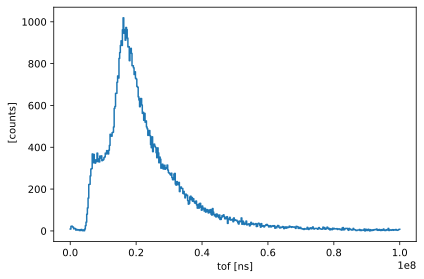

In [17]:
background_monitors['transmission'].plot()

We then call the workflow on the sample and direct runs:

In [18]:
#NOTE: direct monitors is the same as sample (and backgroud)
sample_q = sans.to_I_of_Q(data=binned['sample'],
    data_monitors=sample_monitors,
    direct_monitors=sample_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    monitor_non_background_range=monitor_non_background_range)
sample_q.plot()

An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


DimensionError: Cannot transpose: Requested new dimension order contains different number of labels.

In [ ]:
binned['sample']

In [ ]:
background_q = sans.to_I_of_Q(data=binned['background'],
    data_monitors=background_monitors,
    direct_monitors=background_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    monitor_non_background_range=monitor_non_background_range)
background_q.plot()

We are now in a position to subtract the background from the sample measurement:

In [ ]:
result = sample_q.bins.sum() - background_q.bins.sum()
result

In [ ]:
fig1, ax1 = plt.subplots(1, 2, figsize=(10, 4))
sc.plot(result, ax=ax1[0])
sc.plot(result, norm='log', ax=ax1[1])
fig1

<div class="alert alert-info">

**Note**

Instead of `.bins.sum()`,
one could use `sc.histogram()` above to define different `Q` bins compared to the ones defined at the top of the notebook.
This can be done in event mode, see [here](https://scipp.github.io/user-guide/binned-data/computation.html#Subtraction).

There may be performance advantages to first use a coarse `Q` binning when the computing `I(Q)` numerator,
and use finer binning for the final results.

</div>

## Wavelength bands

It is often useful to process the data in a small number (~10) of separate wavelength bands.

This can be achieved by requesting 10 bands from the `to_I_of_Q` workflow via the `wavelength_bands` argument.

In [ ]:
wavelength_bands = sc.linspace(dim='wavelength', start=2.0, stop=16.0, num=11,
                               unit='angstrom')

sample_slices = sans.to_I_of_Q(data=binned['sample'],
    data_monitors=sample_monitors,
    direct_monitors=direct_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_bands=wavelength_bands,
    monitor_non_background_range=monitor_non_background_range)

background_slices = sans.to_I_of_Q(data=binned['background'],
    data_monitors=background_monitors,
    direct_monitors=direct_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_bands=wavelength_bands,
    monitor_non_background_range=monitor_non_background_range)

result_slices = sample_slices.bins.sum() - background_slices.bins.sum()
result_slices

In [ ]:
collapsed = sc.collapse(result_slices, keep='Q')

fig2, ax2 = plt.subplots(1, 2, figsize=(10, 4))
sc.plot(collapsed, ax=ax2[0])
sc.plot(collapsed, norm='log', legend=False, ax=ax2[1])
fig2

## References

<div id="manasi2021"></div>

Manasi I., Andalibi M. R., Atri R. S., Hooton J., King S. M., Edler K. J., **2021**,
*Self-assembly of ionic and non-ionic surfactants in type IV cerium nitrate and urea based deep eutectic solvent*,
[J. Chem. Phys. 155, 084902](https://doi.org/10.1063/5.0059238)